# MelaNet
## Skin cancer classification
###### Robin Ali - Louise Badarani - Cyriac Parisot - Clément Ponsonnet - Ruoy Zhang

On average between 2 and 3 million skin cancers are diagnosed yearly world wide (World Health Organization). AI has been proven as a powerful diagnostic tool in medical fiels. We thus aim to develop a classifier to help dermathologist assess their diagnostics and understand the most prominent characteristics of each cancer types.

## Data loading

We execute a bash file to load the data from kaggle, organize our images in different folders (test, train, validation) and give the necessary rights to read files. It might take some time.

In [8]:
#To execute only once.
!./downloader.sh

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
mkdir: data: File exists
^C
User cancelled operation


## Requirements

In [ ]:
import os, numpy, PIL, math
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from scipy import misc
from skimage import io, transform

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils

from tqdm import tqdm, tqdm_notebook

## 1. Introduction to the data
The data consists of 10 015 images accompanied by additional information regarding the patients.

In [47]:
from presentation import *

In [4]:
label_dir = 'data/HAM10000_metadata.csv'
image_dir = 'data/images/train/'

In [28]:
df = pd.read_csv(label_dir)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


###### Variable description
* **lesion_id**: ID of lesions
* **image_id**: ID of picture
* **dx**: type of cancer
* **dx_type** : method used for diagnosis
* **age**:  age of patient
* **sex**: sex of patient
* **localization**: localization of the tumor

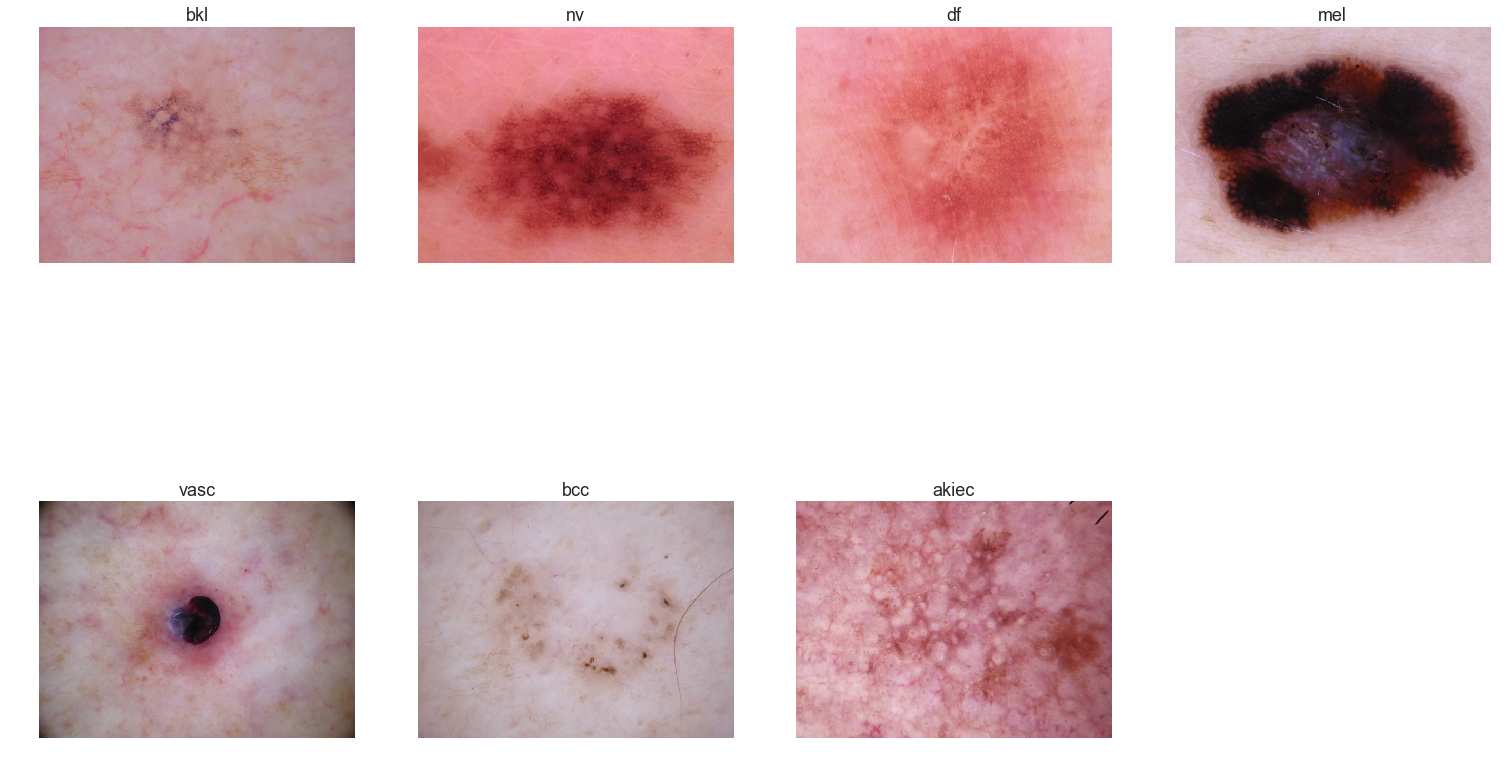

In [25]:
cancer_types = list(df.dx.unique())
images = select_images(df)
plot_images(image_dir, images, cancer_types)

## 2. Quick overview

##### CATEGORY DISTRIBUTION
*dx* corresponds to the type of skin cancer. 7 diseases are being detected:

* actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
* basal cell carcinoma (bcc)
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
* dermatofibroma (df)
* melanoma (mel)
* melanocytic nevi (nv)
* vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).
    
We can see below that the *nv* cancer is over-represented compared to the other types of skin cancer.

In [10]:
sns.set(style="whitegrid", font_scale=1.5)

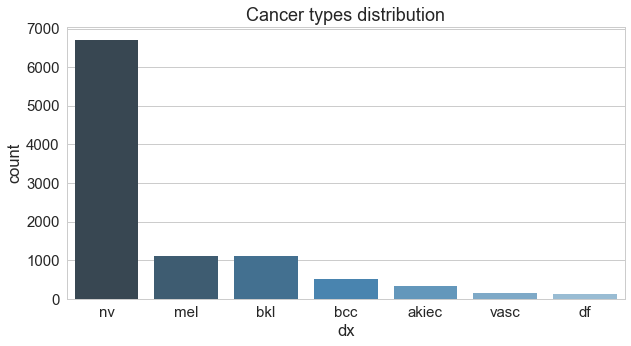

In [11]:
pyplot.subplots(figsize=(10, 5))
sns.countplot(x ='dx', data = df, palette = 'Blues_d', order = df['dx'].value_counts().index).set_title("Cancer types distribution")
plt.show()

##### LABEL DISTRIBUTION

More than 50% of lesions are confirmed through histopathology (histo). The ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal).

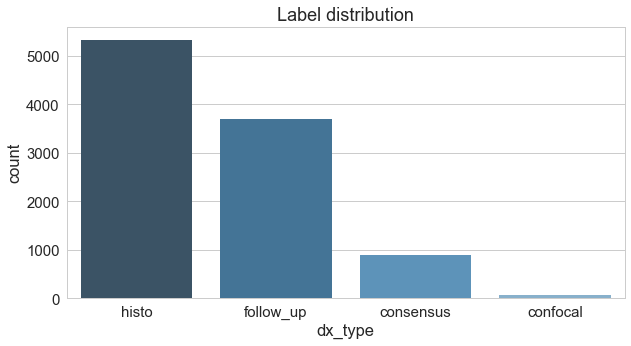

In [32]:
pyplot.subplots(figsize=(10, 5))
sns.countplot(x ='dx_type', data = df, palette = 'Blues_d', order = df['dx_type'].value_counts().index).set_title("Label distribution")
plt.show()

##### AGE

/Users/robinali/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/robinali/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


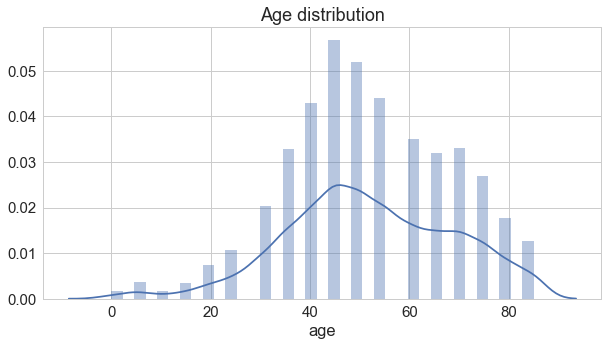

In [12]:
pyplot.subplots(figsize=(10, 5))
sns.distplot(df['age'].dropna()).set_title("Age distribution")
plt.show()

##### GENDER

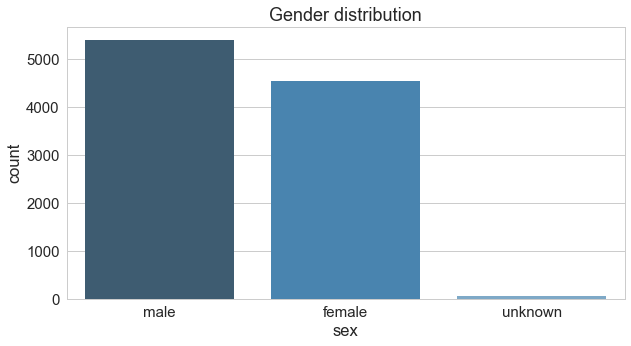

In [13]:
pyplot.subplots(figsize=(10, 5))
sns.countplot(x ='sex', data = df, palette = 'Blues_d').set_title("Gender distribution")
plt.show()

##### LOCALIZATION

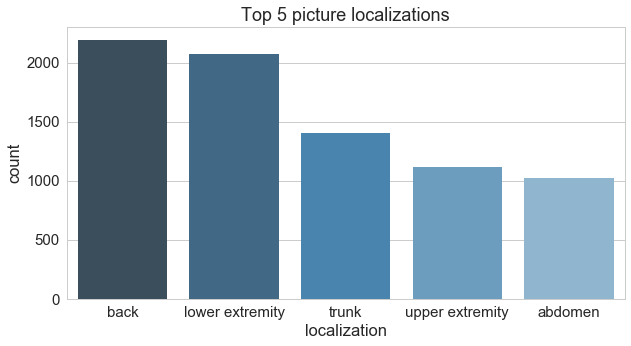

In [14]:
pyplot.subplots(figsize=(10, 5))
sns.countplot(x ='localization', data = df, palette = 'Blues_d', order = df['localization'].value_counts().iloc[:5].index).set_title("Top 5 picture localizations")
plt.show()

## 3. Building an average image for categories

In [21]:
files_dir = 'data/images/train/'

In [22]:
# Access all PNG files in directory
allfiles=os.listdir(files_dir)

In [33]:
for category in tqdm_notebook(df['dx'].unique()):
    
    # Create a numpy array of floats to store the average
    arr=numpy.zeros((450,600,3),numpy.float)    
    imlist=[filename for filename in allfiles if  filename[:-4] in list(df[df['dx'] == category]['image_id'])]
    N = len(imlist)
    
    for im in imlist:
        imarr=numpy.array(Image.open(files_dir+im),dtype=numpy.float)
        arr=arr+imarr/N

    # Round values in array and cast as 8-bit integer
    arr=numpy.array(numpy.round(arr),dtype=numpy.uint8)

    # Generate, save and preview final image
    out=Image.fromarray(arr,mode="RGB")
    out.save('average/'+category + '.png')
    out.show()

A Jupyter Widget

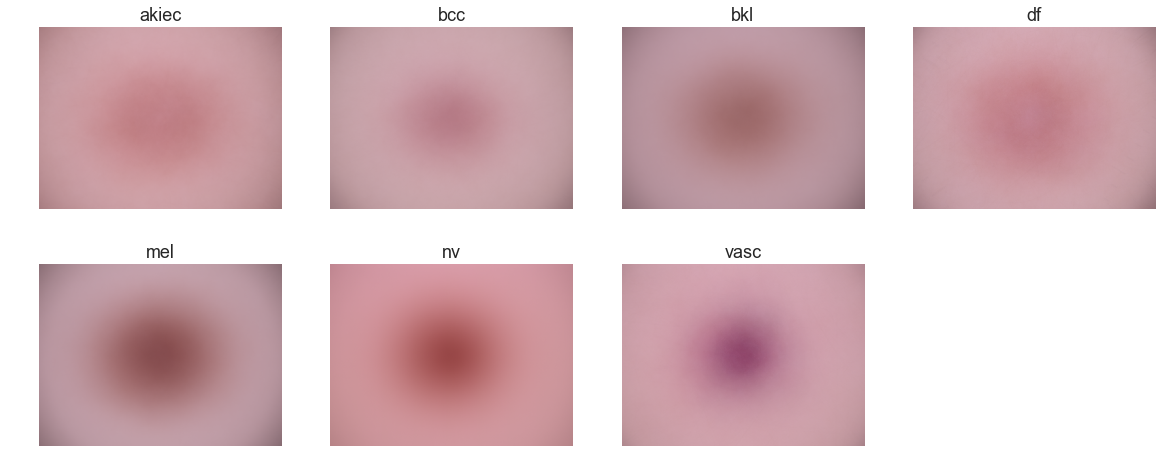

In [24]:
rows = 2
files = os.listdir('average/')
fig = plt.figure(1)
fig.set_size_inches(w=20,h=8)

for num, x in enumerate(files):
    img = PIL.Image.open('average/'+x)
    plt.subplot(rows,4,num+1)
    plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)
plt.show()

## 4. Training our VGG16 model

To build our model, we decided to use a VGG16 neural network. VGG16 has been pre-trained on the 1,000 different categories available on Imagenet. We tried two different approaches to build our model:

* **Transfer Learning:** we removed the last layer and replaced it with a fully-connected linear layer predicting the 7 types of skin cancer.

* **Fine Tuning:** we unfroze the 5 last layers and re-trained the model using our dataset.

The data is split between a training set (70%), a validation set (20%) and a test set (10%).

### DATA LOADER

**Arguments:**
* csv_file (string): Path to the csv file with labels.
* data_dir (string): Directory with all the images.
* transform (callable, optional): Optional transform to be applied on a sample: use prep1

**Pytorch transformer:**

* **Data cleaning:** Our neural network has been pre-trained on 224 x 224 px images whereas input images are 600 x 450 px. Resizing and croping are necessary to adapt our image format. 

* **Data augmentation: **The transformer will be applied at each epoch. Color jitter, random rotations and flips enable us to train the neural network with different inputs at each epoch (data augmentation).

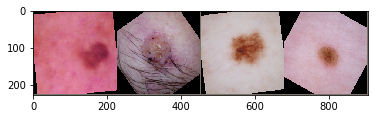

In [37]:
class MelaData(Dataset):
    def __init__(self, data_dir, label_csv, transform=None):

        self.data_dir = data_dir
        self.files = os.listdir(data_dir)
        labels = pd.read_csv(label_csv)
        
        # Assigning a number to each cancer type
        dx_to_num = {'nv' : 0, 'mel': 1, 'bkl': 2, 'df': 3, 'akiec': 4, 'bcc': 5, 'vasc' : 6}        
        labels['label'] = labels['dx'].apply(lambda x: dx_to_num[x])
        self.labels = labels
        
        if transform is None:
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            transform = transforms.Compose([
                
                # Data cleaning steps
                transforms.Resize(224),
                transforms.CenterCrop(224),
                
                # Data augmentation steps
                transforms.ColorJitter(hue=.05, saturation=.05),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(360, resample=Image.BILINEAR),
                
                transforms.ToTensor(),
                normalize,
                ])

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_name_with_extension = self.files[idx]
        image = Image.open(self.data_dir + image_name_with_extension)
        image_name = image_name_with_extension.strip('.jpg')

        if self.transform:
            image = self.transform(image)    

        label = self.labels.loc[self.labels['image_id'] == image_name, 'label']
        label = np.array(label)
        label_t = torch.from_numpy(label)[0]
        return(image, label_t)

### MODEL CLASS

##### VGG16 structure

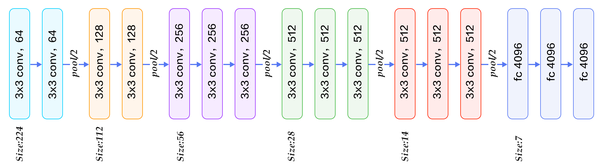

##### Training strategy

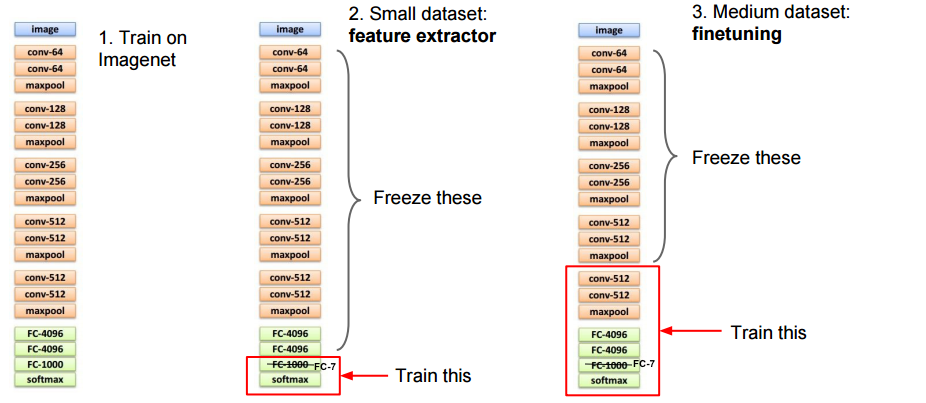

##### Code

In [ ]:
class vgg_preloaded(nn.Module):

    def __init__(self, num_class, use_cuda):
        super(vgg_preloaded, self).__init__()
        self.use_cuda = use_cuda
        self.num_class = num_class
        self.dtype = torch.cuda.FloatTensor if self.use_cuda else torch.FloatTensor
        
        # We use the pre-trained model
        model = models.vgg16(pretrained=True) 
        self.model = model.cuda() if self.use_cuda else model
        
        # We freeze all the layers
        for param in self.model.features.parameters():
            param.require_grad = False
        num_features = self.model.classifier[6].in_features
        
        # We remove the last layer
        features = list(self.model.classifier.children())[:-1] 
        
        # We add a linear (unfrozen) layer at the end of our network to predict the 7 classes
        features.extend([nn.Linear(num_features, self.num_class)])
        self.model.classifier = nn.Sequential(*features)
        self.model.classifier.require_grad = True

    def forward(self, inp):
        return(self.model(inp))

### Training

You can find the code here: [vgg_pretrained.py](vgg_pretrained.py). 

We decided to use:

* **torch.nn.CrossEntropyLoss():** a loss function for categorical data.
* **Adam():** an optimizer that works well in most cases
* [www.paperspace.com](www.paperspace.com) virtual machines to train our model on **GPU**.

Note: We did not have time to run it but we explored addoing weights in the Loss function with the 'weights' parameter to deal with the class imbalance (almost 70% of data is one category). We also explored Xavier initialisation for our last fully connected layer.

In [36]:
from vgg_pretrained import *

In [43]:
data_dir = 'data/images/train_presentation_test/'
save_dir = 'model/'

In [44]:
# Live test with 50 images in the training sample
train(data_dir, label_dir, save_dir=save_dir, epoch=120, mb=4, num_class=7, use_cuda=False, name = 'model',
      num_workers = 1, conti = False, lr = 1e-4, save = True)



  0%|          | 0/8 [00:00<?, ?it/s]

[Epoch 1]:   0%|          | 0/8 [00:00<?, ?it/s]

[Epoch 1]:  12%|█▎        | 1/8 [00:11<01:17, 11.00s/it]

[Epoch 1]:  25%|██▌       | 2/8 [00:20<01:01, 10.31s/it]

[Epoch 1]:  38%|███▊      | 3/8 [00:29<00:49,  9.99s/it]

[Epoch 1]:  50%|█████     | 4/8 [00:38<00:38,  9.67s/it]

[Epoch 1]:  62%|██████▎   | 5/8 [00:46<00:28,  9.36s/it]

[Epoch 1]:  75%|███████▌  | 6/8 [00:54<00:18,  9.04s/it]

[Epoch 1]:  88%|████████▊ | 7/8 [01:01<00:08,  8.84s/it]

[Epoch 1]: 100%|██████████| 8/8 [01:06<00:00,  8.27s/it]



  0%|          | 0/8 [00:00<?, ?it/s]

[Epoch 2]:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 1.4932 Acc: 0.5667




[Epoch 2]:  12%|█▎        | 1/8 [00:11<01:17, 11.09s/it]

[Epoch 2]:  25%|██▌       | 2/8 [00:22<01:06, 11.07s/it]

[Epoch 2]:  38%|███▊      | 3/8 [00:32<00:53, 10.70s/it]

[Epoch 2]:  50%|█████     | 4/8 [00:41<00:41, 10.33s/it]

[Epoch 2]:  62%|██████▎   | 5/8 [00:50<00:30, 10.04s/it]

[Epoch 2]:  75%|███████▌  | 6/8 [00:58<00:19,  9.72s/it]

[Epoch 2]:  88%|████████▊ | 7/8 [01:05<00:09,  9.40s/it]

[Epoch 2]: 100%|██████████| 8/8 [01:09<00:00,  8.74s/it]



  0%|          | 0/8 [00:00<?, ?it/s]

[Epoch 3]:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 1.2055 Acc: 0.7333




[Epoch 3]:  12%|█▎        | 1/8 [00:10<01:13, 10.46s/it]

[Epoch 3]:  25%|██▌       | 2/8 [00:21<01:04, 10.67s/it]

[Epoch 3]:  38%|███▊      | 3/8 [00:30<00:51, 10.33s/it]

[Epoch 3]:  50%|█████     | 4/8 [00:40<00:40, 10.19s/it]

[Epoch 3]:  62%|██████▎   | 5/8 [00:51<00:30, 10.22s/it]

[Epoch 3]:  75%|███████▌  | 6/8 [01:00<00:20, 10.03s/it]

[Epoch 3]:  88%|████████▊ | 7/8 [01:07<00:09,  9.67s/it]

[Epoch 3]: 100%|██████████| 8/8 [01:11<00:00,  8.99s/it]



  0%|          | 0/8 [00:00<?, ?it/s]

[Epoch 4]:   0%|          | 0/8 [00:00<?, ?it/s]

Train - Loss: 0.9114 Acc: 0.7333


Process Process-6:
Traceback (most recent call last):
  File "/Users/robinali/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/robinali/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/robinali/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/Users/robinali/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/Users/robinali/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/Users/robinali/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Users/robinali/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = 

KeyboardInterrupt: 

## 6. Testing the model & Performance

Here we run a live demo of classification

In [15]:
from vgg_pretrained import vgg_preloaded, MelaData, train, train_val_test_split, test_model
import pickle
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [30]:
def preprocess_image(img):
	means=[0.485, 0.456, 0.406]
	stds=[0.229, 0.224, 0.225]

	preprocessed_img = img.copy()[: , :, ::-1]
	for i in range(3):
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
	preprocessed_img = \
		np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
	preprocessed_img = torch.from_numpy(preprocessed_img)
	preprocessed_img.unsqueeze_(0)
	inp = preprocessed_img
	#inp.requires_grad = True
	return(inp)

In [57]:
data_dir = '/home/paperspace/projects/skin_cancer/data/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'
label_dir = '/home/paperspace/projects/skin_cancer/data/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
save_dir = '/home/paperspace/projects/skin_cancer/data/res_model/'
model_name = 'test_model_100_loss_0_1995_acc_0_9248.pt'
name = save_dir + model_name
cuda = True
meta = pd.read_csv(label_dir)
with open('num2name.pickle','rb') as handle:
    num2name = pickle.load(handle)

In [44]:
model = vgg_preloaded(7, use_cuda = cuda)
model.load_state_dict(torch.load(name))
model.model.requires_grad = True
model = model.cuda()

In [45]:
image_num = 29111
image_name = 'ISIC_00{}.jpg'.format(str(image_num))
image_dir = data_dir + image_name
img = cv2.imread(image_dir, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
img = preprocess_image(img)
img = img.cuda()

In [52]:
outputs = model(img)
_,preds = torch.max(outputs.data, 1)

In [58]:
num2name[preds.cpu().data.numpy()[0]]

'melanocytic_nevi'

### We ran the test function and obtained the following results

You can find the code here: [test.py](test.py). 

#### Test res
- Accuracy: 92%
- loss: 0.238

vs
#### Train res
- Accuracy: 92%
- loss: 0.198

## 7.  Gradient Class Activation Heatmap (GradCam)

